In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
#from sklearn_pandas import CategoricalImputer

In [13]:
d = '/Users/joseph/Downloads/house-prices-advanced-regression-techniques'

In [14]:
files = os.listdir(d)
files

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']

In [15]:
'''DESCRIPTION OF THE FEATURES'''
with open(os.path.join(d,files[1])) as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [16]:
def readData(filePath):
    file = pd.read_csv(filePath)   
    
    #drop columns that have more than 80% null values
    
    cols=[]
    for index, value in (file.isnull().sum() /len(file)).items():
        if value > 0.8:
            cols.append('{}'.format(index))
    cols.extend(['Id'])
    file=file.drop(columns=cols)

    return file

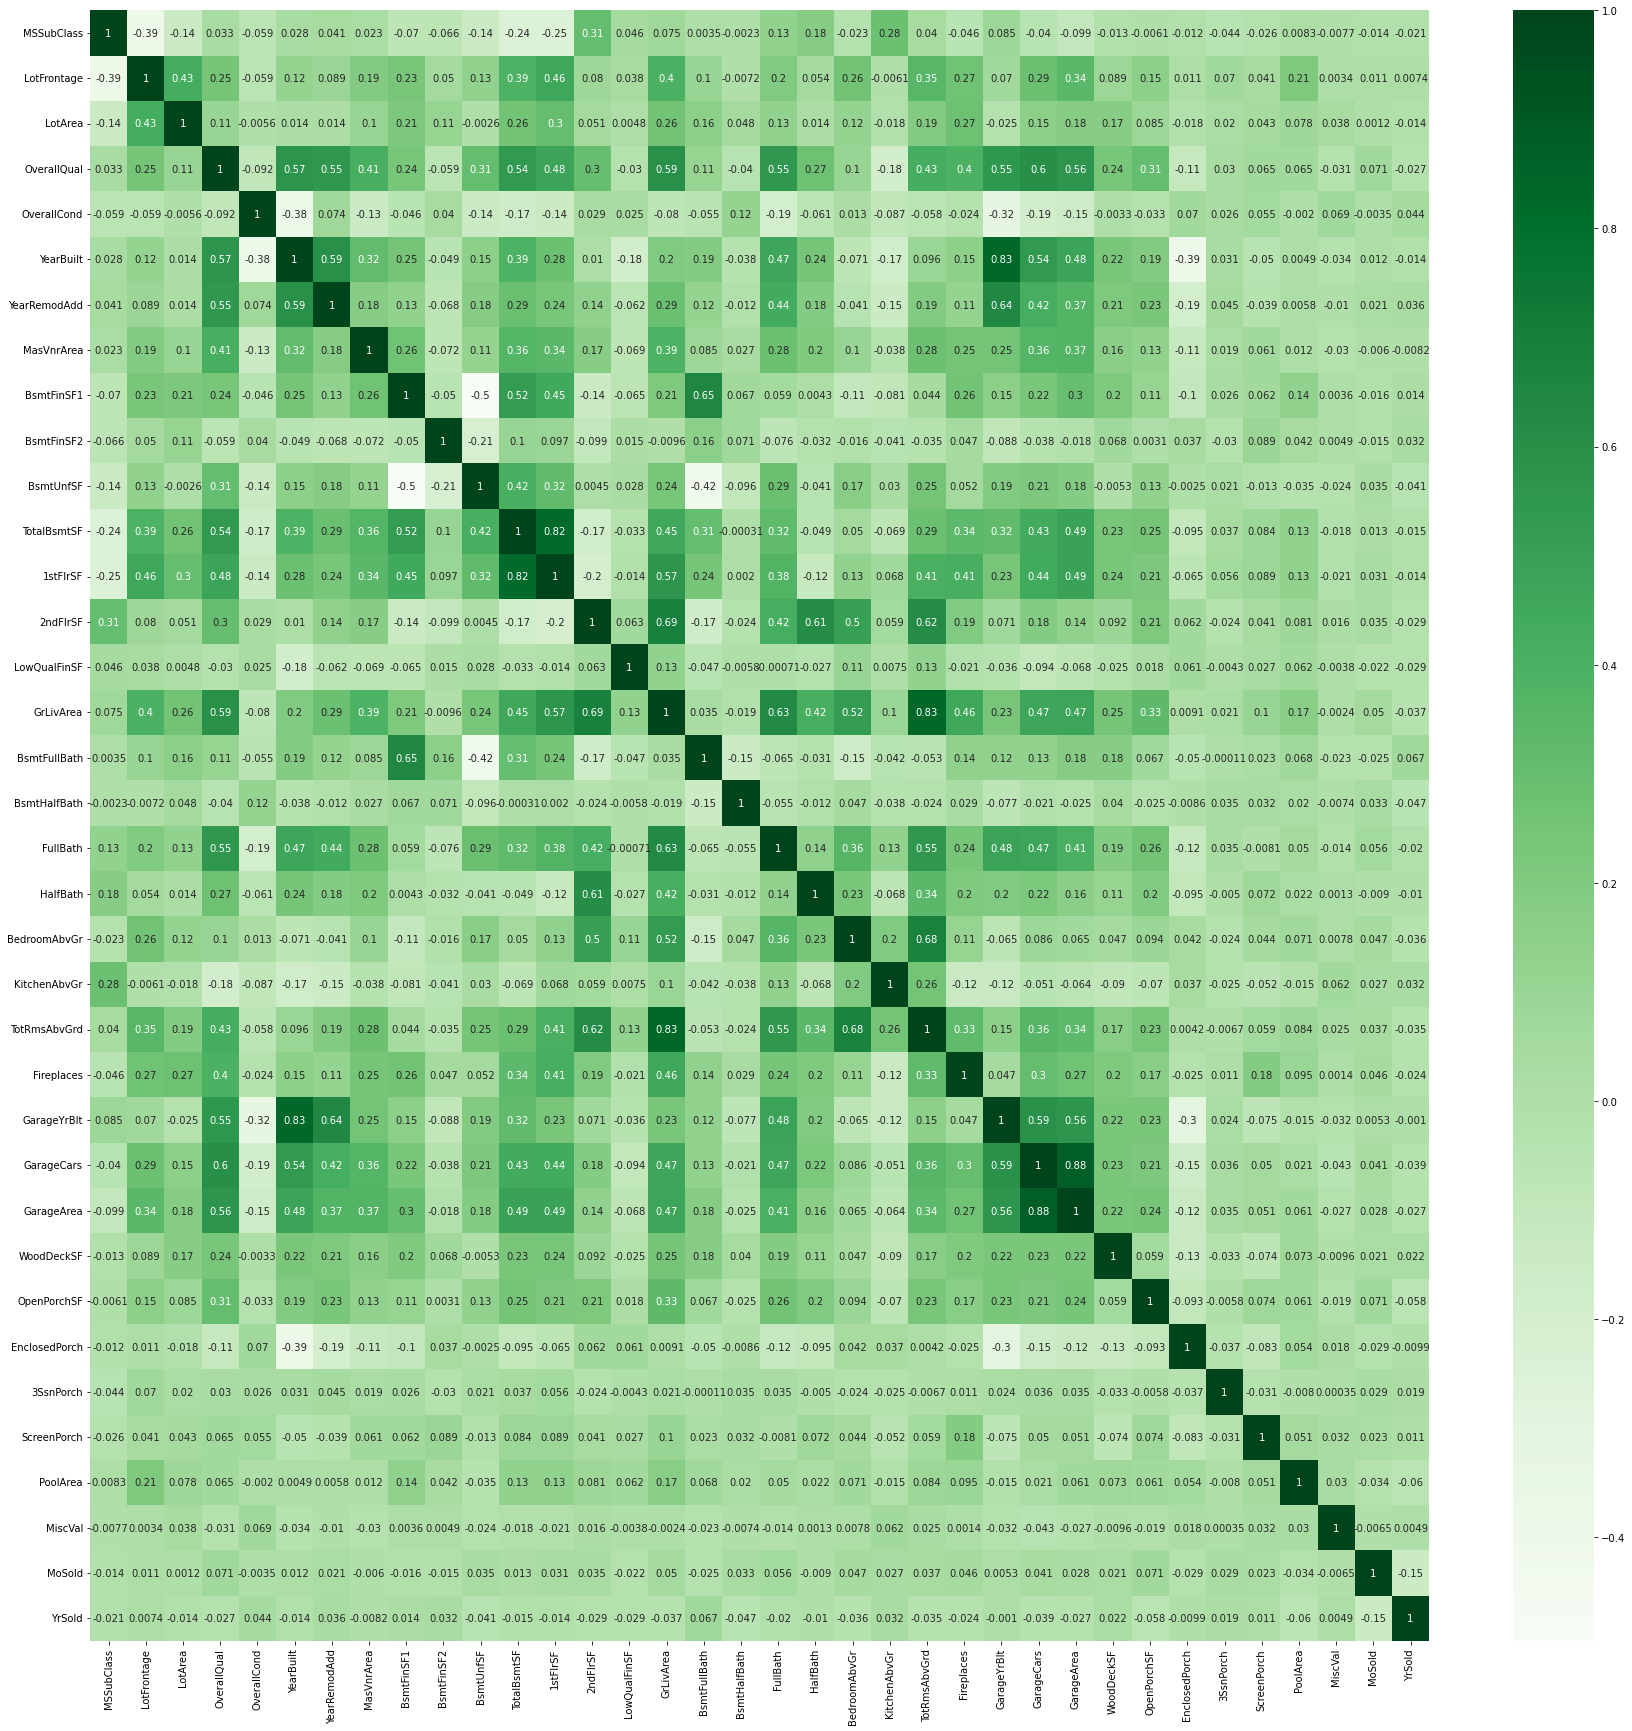

In [17]:
X = readData(os.path.join(d,files[2]))
corr = X.select_dtypes("number").drop(columns=['SalePrice']).corr()
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr,annot=True,cmap='Greens',ax=ax);

In [18]:
'''Fill in the null/missing integer values'''
imp = SimpleImputer()
X[X.select_dtypes('number').columns] = imp.fit_transform(X.select_dtypes('number'))

In [19]:
'''Fill in missing categorical variabes with most frequent values'''
X=X.apply(lambda x: x.fillna(x.value_counts().index[0]))
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500.0
1,20.0,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500.0
2,60.0,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500.0
3,70.0,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,60.0,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,RL,62.0,7917.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,WD,Normal,175000.0
1456,20.0,RL,85.0,13175.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,WD,Normal,210000.0
1457,70.0,RL,66.0,9042.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,WD,Normal,266500.0
1458,20.0,RL,68.0,9717.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,WD,Normal,142125.0


In [20]:
'''CATEGORICAL FEATURE ENGINEERING'''
cond = X.dtypes == 'object'
var = (cond[cond]).index.tolist() #get index of categorical variables
encoder = CountFrequencyEncoder(encoding_method='frequency', variables=var)
encoder.fit(X)
X = encoder.transform(X)

In [21]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,0.788356,65.0,8450.0,0.99589,0.633562,0.897945,0.999315,0.720548,0.946575,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,0.867808,0.820548,208500.0
1,20.0,0.788356,80.0,9600.0,0.99589,0.633562,0.897945,0.999315,0.032192,0.946575,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,0.867808,0.820548,181500.0
2,60.0,0.788356,68.0,11250.0,0.99589,0.331507,0.897945,0.999315,0.720548,0.946575,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,0.867808,0.820548,223500.0
3,70.0,0.788356,60.0,9550.0,0.99589,0.331507,0.897945,0.999315,0.180137,0.946575,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,0.867808,0.069178,140000.0
4,60.0,0.788356,84.0,14260.0,0.99589,0.331507,0.897945,0.999315,0.032192,0.946575,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,0.867808,0.820548,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,0.788356,62.0,7917.0,0.99589,0.633562,0.897945,0.999315,0.720548,0.946575,...,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,0.867808,0.820548,175000.0
1456,20.0,0.788356,85.0,13175.0,0.99589,0.633562,0.897945,0.999315,0.720548,0.946575,...,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,0.867808,0.820548,210000.0
1457,70.0,0.788356,66.0,9042.0,0.99589,0.633562,0.897945,0.999315,0.720548,0.946575,...,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,0.867808,0.820548,266500.0
1458,20.0,0.788356,68.0,9717.0,0.99589,0.633562,0.897945,0.999315,0.720548,0.946575,...,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,0.867808,0.820548,142125.0


In [22]:
y = X['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['SalePrice']), y, test_size=0.10, random_state=42)

In [38]:
def checkAccuracy(y_val,y_pred):
    resid  = abs(y_pred - y_val)
    accuracy = 100 - np.mean((100 * (resid / y_val)))
    return accuracy

In [67]:
models = dict()
for i in range(10, len(X_train.columns)+1):
    model_pca = make_pipeline(StandardScaler(),PCA(n_components=i),LinearRegression())
    model_pca.fit(X_train, y_train)
    models["Model with {} features".format(i)] = checkAccuracy(y_train, model_pca.predict(X_train))

#get the model with highest accuracy

key_list = list(models.keys())
value_list = list(models.values())
print("{} had the highest accuracy at {}%".format(key_list[value_list.index(max(models.values()))]
                                                 ,max(models.values())))

Model with 70 features had the highest accuracy at 88.91465008278978%


In [71]:
#make the best model.
model_lr = make_pipeline(StandardScaler(),PCA(n_components=70),LinearRegression())
model_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=70)),
                ('linearregression', LinearRegression())])

In [87]:
y_pred_training = model_lr.predict(X_train)
print("Linear regression training accuracy is {}%".format(round(checkAccuracy(y_train, y_pred_training))))

Linear regression training accuracy is 89%


In [73]:
#Predictions from the linear regression model
pd.DataFrame({'Actual':y_train, 'Predicted':y_pred_training})

,Actual,Predicted
907,250000.0,220198.726568
782,187100.0,201031.658077
952,133900.0,120579.380473
620,67000.0,45481.021235
669,137500.0,138063.995017
...,...,...
1095,176432.0,177487.048036
1130,135000.0,148239.187056
1294,115000.0,134291.537491
860,189950.0,174634.961293


In [88]:
y_pred_test = model_lr.predict(X_test)
print("Linear regression testing accuracy is {}%".format(round(checkAccuracy(y_test, y_pred_test))))

Linear regression testing accuracy is 88%


In [75]:
#-------Random forest trees-------#
RFModel = RandomForestRegressor(n_estimators=1000)
RFModel.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000)

In [76]:
RF_pred_train = RFModel.predict(X_train)

In [84]:
print("Random forest training accuracy is {}%".format(round(checkAccuracy(RF_pred_train, y_train))))

Random forest training accuracy is 96%


In [78]:
#Predictions from the random forest tree model
pd.DataFrame({'Actual':y_train, 'Predicted':RF_pred_train})

,Actual,Predicted
907,250000.0,238230.127
782,187100.0,190843.736
952,133900.0,132454.094
620,67000.0,70659.799
669,137500.0,124679.950
...,...,...
1095,176432.0,179381.721
1130,135000.0,147296.272
1294,115000.0,117442.981
860,189950.0,177675.393


In [89]:
print("Random forest testing accuracy is {}%".format(round(checkAccuracy(RFModel.predict(X_test), y_test))))

Random forest testing accuracy is 91%
